# Experiments wth the linear regression model

In [40]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers, Model, Input, metrics, optimizers, losses
import numpy as np
import os
import shutil
from keras import backend as K
from keras.callbacks import History

# Dict to map model type with filepath
model_type_to_filepath = {"core_model": "/models/core_model", "dram_model": "/models/dram_model"}

core_model_labels = {
                "numerical_labels": ["curr_cpu_cycles", "current_cpu_instructions", "curr_cpu_time"],
                "categorical_string_labels": ["cpu_architecture"] }

dram_model_labels = {
                    "numerical_labels": ["curr_resident_memory", "curr_cache_misses"],
                    "categorical_string_labels": ["cpu_architecture"]}

categorical_label_to_vocab = {
                            "cpu_architecture": ["Sandy Bridge", "Ivy Bridge", "Haswell", "Broadwell", "Sky Lake", "Cascade Lake", "Coffee Lake", "Alder Lake"] }


def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Generates a Core regression model which predicts curr_energy_in_core given
# numerical features (curr_cpu_cycles, current_cpu_instructions, curr_cpu_time).
# Consumes a tensorflow dataset with no missing data and all required features and 
# target. This Regression model will be saved on server.
def generate_core_regression_model(core_train_dataset: tf.data.Dataset) -> Model:
    all_features_to_modify = []
    input_list = []
    #normalizing numerical features with given dataset
    for numerical_column in core_model_labels["numerical_labels"]:
        new_input = Input(shape=(1,), name=numerical_column) # single list with one constant
        new_normalizer_name = "normalization_" + numerical_column
        new_normalizer = layers.Normalization(axis=None, name=new_normalizer_name)
        new_normalizer.adapt(core_train_dataset.map(lambda x, y: x[numerical_column]))
        all_features_to_modify.append(new_normalizer(new_input))
        input_list.append(new_input)
    # encoding categorical feature with given data immediately (can also write this as a new model)
    for categorical_column in core_model_labels["categorical_string_labels"]:
        new_input = Input(shape=(1, ), name=categorical_column, dtype='string') # single list with one constant
        new_int_index = layers.StringLookup(vocabulary=categorical_label_to_vocab[categorical_column], num_oov_indices=0)
        #new_int_index.adapt(core_train_dataset.map(lambda x, y: x[categorical_column]))
        new_layer = layers.CategoryEncoding(num_tokens=new_int_index.vocabulary_size(), output_mode='one_hot') # no relationship between categories
        all_features_to_modify.append(new_layer(new_int_index(new_input)))
        input_list.append(new_input)
    
    all_features = layers.concatenate(all_features_to_modify)
    single_regression_layer = layers.Dense(units=1, activation='linear', name="linear_regression_layer")(all_features)
    new_linear_model = Model(input_list, single_regression_layer)
    new_linear_model.compile(optimizer=optimizers.Adam(learning_rate=0.5), loss='mse', metrics=[coeff_determination, metrics.RootMeanSquaredError()])
    return new_linear_model
    

In [46]:
import pandas as pd
import tensorflow as tf
import numpy as np
#from kepler_model_trainer import generate_core_regression_model
import os
from keras.callbacks import History 


core_dataframe = pd.read_csv("real_test_datasets/metrics.csv", header=0, sep=',')
core_dataframe.pop("curr_energy_in_dram")
core_dataframe.pop("curr_resident_memory")
core_dataframe.pop("curr_cache_misses")
core_dataframe.pop("Unnamed: 8")
core_dataframe.pop("Unnamed: 9")
train_dataframe, validation_dataframe, test_dataframe = np.split(core_dataframe.sample(frac=1), [int(0.6 * len(core_dataframe)), int(0.8 * len(core_dataframe))])
train_labels_df = train_dataframe.pop("curr_energy_in_core")
validation_labels_df = validation_dataframe.pop("curr_energy_in_core")
test_labels_df = test_dataframe.pop("curr_energy_in_core")

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_dataframe), train_labels_df))
train_dataset = train_dataset.shuffle(len(train_dataset)).repeat(4).batch(32)
validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_dataframe), validation_labels_df))
validation_dataset = validation_dataset.batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_dataframe), test_labels_df))
test_dataset = test_dataset.batch(32)

#train_model_given_data_and_type(train_dataset, validation_dataset, test_dataset, "core_model")
new_model = generate_core_regression_model(train_dataset)
history = History()
new_model.fit(train_dataset, epochs=125, validation_data=validation_dataset, callbacks=[history])
loss_result, r_squared, rmse_metric = new_model.evaluate(test_dataset)
print("Mean Squared Error: {}".format(loss_result))
print("R Squared: {}".format(r_squared))
print("Root Mean Squared Error: {}".format(rmse_metric))


Epoch 1/125


/opt/app-root/lib64/python3.8/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


1990/1990 [==============================] - 4s 2ms/step - loss: 33439748096.0000 - coeff_determination: -62.8299 - root_mean_squared_error: 182865.3750 - val_loss: 32893857792.0000 - val_coeff_determination: -62.0622 - val_root_mean_squared_error: 181366.6406
Epoch 2/125
1990/1990 [==============================] - 4s 2ms/step - loss: 32720779264.0000 - coeff_determination: -61.6439 - root_mean_squared_error: 180888.8594 - val_loss: 32182978560.0000 - val_coeff_determination: -60.6992 - val_root_mean_squared_error: 179396.1562
Epoch 3/125
1990/1990 [==============================] - 4s 2ms/step - loss: 32010926080.0000 - coeff_determination: -60.0035 - root_mean_squared_error: 178915.9688 - val_loss: 31480532992.0000 - val_coeff_determination: -59.3523 - val_root_mean_squared_error: 177427.5469
Epoch 4/125
1990/1990 [==============================] - 4s 2ms/step - loss: 31309019136.0000 - coeff_determination: -58.7560 - root_mean_squared_error: 176943.5469 - val_loss: 30786070528.0000

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [48]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

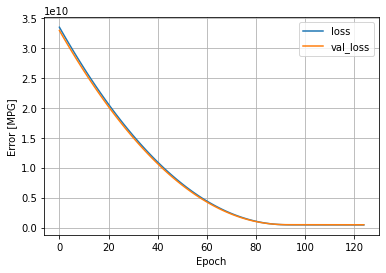

In [49]:
plot_loss(history)